# Analysis of AirBnb data from Munich

This project aims to get a better understanding of the AirBnB market in Munich.
Therefore I'll try to find answers to the following four questions:

1. Which time is the most expensive to travel to Munich?

2. Is booking earlier cheaper than booking short time in advance and how do prices change over time?

3. Is it possible to build a model to automatically suggest a price to new hosts starting with AirBnb?

4. Which factors influence the prices most and how do they influence them?



In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os

In [3]:
calendar = pd.read_csv("../data/raw/munich/2020-05-24/calendar.csv.gz",compression="gzip")
listings = pd.read_csv("../data/raw/munich/2020-05-24/listings.csv.gz",compression="gzip")
reviews = pd.read_csv("../data/raw/munich/2020-05-24/reviews.csv.gz",compression="gzip")


In [2]:
def calc_missing_data(df: pd.DataFrame, plot=False) -> pd.DataFrame:
    """
    Calculates number of missing values.
    Input:
    df - pd.DataFrame containing the data
    plot - default: False, change to True to plot a bar chart

    Return:
    pd.DataFrame with missing data per column
    """
    missing = df.isna().sum().rename("missing_total").to_frame()
    missing["ratio"] = missing / len(df)
    if plot:
        plt.figure(figsize=(12,6))
        plt.title("Missing values in %")
        missing.loc[missing["ratio"]>0, "ratio"].sort_values().plot.bar()
        plt.show()
    return missing


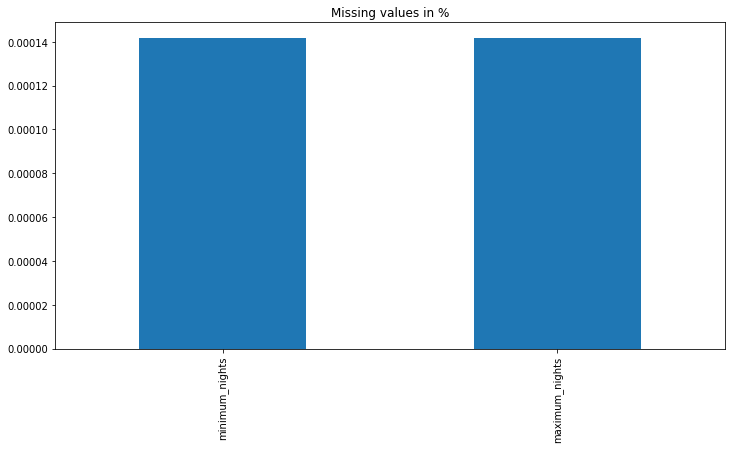

,missing_total,ratio
listing_id,0,0.000000
date,0,0.000000
available,0,0.000000
price,0,0.000000
adjusted_price,0,0.000000
minimum_nights,576,0.000142
maximum_nights,576,0.000142


In [5]:
calc_missing_data(calendar, True)

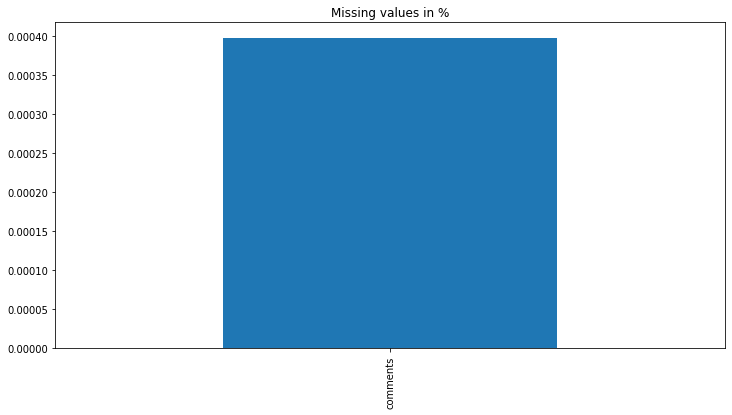

,missing_total,ratio
listing_id,0,0.000000
id,0,0.000000
date,0,0.000000
reviewer_id,0,0.000000
reviewer_name,0,0.000000
comments,68,0.000398


In [6]:
calc_missing_data(reviews, True)

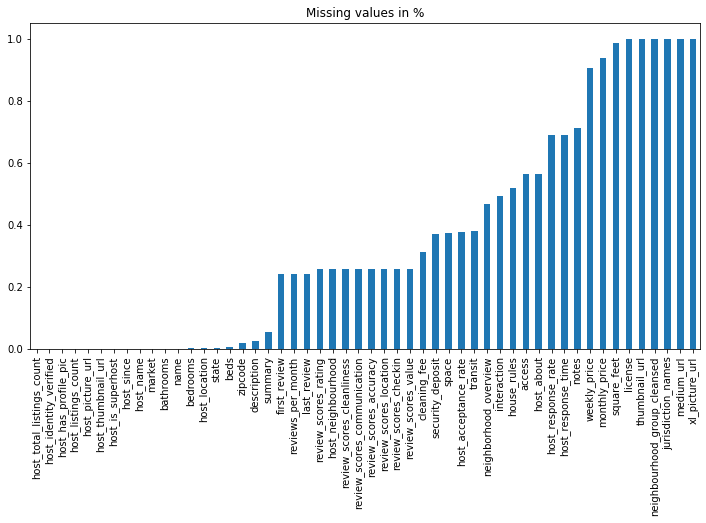

,missing_total,ratio
id,0,0.000000
listing_url,0,0.000000
scrape_id,0,0.000000
last_scraped,0,0.000000
name,20,0.001797
...,...,...
calculated_host_listings_count,0,0.000000
calculated_host_listings_count_entire_homes,0,0.000000
calculated_host_listings_count_private_rooms,0,0.000000
calculated_host_listings_count_shared_rooms,0,0.000000


In [7]:
calc_missing_data(listings, True)

In [8]:
calendar.loc[calendar["listing_id"]==36720, "price"].value_counts()

$95.00    365
Name: price, dtype: int64

In [12]:
calendar.groupby("listing_id")["price"].nunique()

listing_id
36720       1
49309       1
97945       2
114695      3
127383      1
           ..
43530556    6
43530747    5
43532497    1
43533356    8
43535486    1
Name: price, Length: 11128, dtype: int64

In [75]:
calendar.date.min()

'2020-05-25'

In [34]:
calendar["price"] = calendar["price"].str.replace("\\$|\\,","", regex=True)
calendar["price"] = calendar["price"].astype(np.float16)

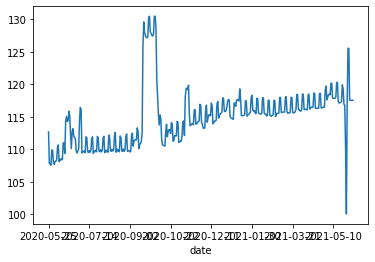

In [36]:
calendar.groupby("date")["price"].mean().plot()

In [68]:
calendar2 = pd.read_csv(""../data/raw/munich/"2020-04-25/calendar.csv.gz",compression="gzip")


In [72]:
calendar2["price"] = calendar2["price"].str.replace("\\$|\\,","", regex=True)
calendar2["price"] = calendar2["price"].astype(np.float16)

In [85]:
set1 = set(calendar.date)
set2 = set(calendar2.date)

In [87]:
calendar2.shape

(4062815, 7)

In [3]:
def format_price(price: pd.Series):
    """
    Removes dollar signs and comma from a series of prices
    Input:
    - price: pd.Series containing the prices

    Returns:
    - formatted pd.Series with prices as float16
    """
    price = price.str.replace("\\$|\\,","", regex=True)
    price = price.astype(np.float16)
    return price



In [98]:
merged =calendar.merge(calendar2, on=["listing_id", "date"])

In [102]:
merged[(merged["price_x"] != merged["price_y"])]

,listing_id,date,available_x,price_x,adjusted_price_x,minimum_nights_x,maximum_nights_x,available_y,price_y,adjusted_price_y,minimum_nights_y,maximum_nights_y
1205,172672,2020-08-01,f,56.0,$56.00,1.0,4.0,f,58.0,$58.00,1,4
1206,172672,2020-08-02,f,56.0,$56.00,1.0,4.0,f,58.0,$58.00,1,4
1207,172672,2020-08-03,f,56.0,$56.00,1.0,4.0,f,58.0,$58.00,1,4
1208,172672,2020-08-04,f,56.0,$56.00,1.0,4.0,f,58.0,$58.00,1,4
1209,172672,2020-08-05,f,56.0,$56.00,1.0,4.0,f,58.0,$58.00,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
3640124,43148613,2021-04-20,f,18.0,$18.00,3.0,1125.0,f,27.0,$27.00,3,1125
3640125,43148613,2021-04-21,f,18.0,$18.00,3.0,1125.0,f,27.0,$27.00,3,1125
3640126,43148613,2021-04-22,f,18.0,$18.00,3.0,1125.0,f,27.0,$27.00,3,1125
3640127,43148613,2021-04-23,f,18.0,$18.00,3.0,1125.0,f,27.0,$27.00,3,1125


In [4]:
scrape_dates = os.listdir("../data/raw/munich/")

In [39]:
calendar = pd.DataFrame(columns=["listing_id","date"])
for date in scrape_dates:
    path = "".join(["../data/raw/munich/", date, "/calendar.csv.gz"])
    print(path)
    c = pd.read_csv(path, compression="gzip")
    c = c.drop(columns=["adjusted_price","minimum_nights","maximum_nights"])
    c["price"] = format_price(c["price"])
    calendar = calendar.merge(c, on=["listing_id", "date"], how="outer", suffixes=("","_"+date))



../data/raw/munich/2019-03-15/calendar.csv.gz
../data/raw/munich/2019-05-22/calendar.csv.gz
../data/raw/munich/2019-06-24/calendar.csv.gz
../data/raw/munich/2019-07-16/calendar.csv.gz
../data/raw/munich/2019-08-24/calendar.csv.gz
../data/raw/munich/2019-09-24/calendar.csv.gz
../data/raw/munich/2019-10-20/calendar.csv.gz
../data/raw/munich/2019-11-25/calendar.csv.gz
../data/raw/munich/2019-12-26/calendar.csv.gz
../data/raw/munich/2020-01-22/calendar.csv.gz
../data/raw/munich/2020-02-27/calendar.csv.gz
../data/raw/munich/2020-03-19/calendar.csv.gz
../data/raw/munich/2020-04-25/calendar.csv.gz
../data/raw/munich/2020-05-24/calendar.csv.gz


In [40]:
calendar.shape

(10968366, 30)

In [47]:
calendar.to_pickle("../data/processed/calendar_merged.pkl")

In [53]:
calendar.listing_id.nunique()

17287

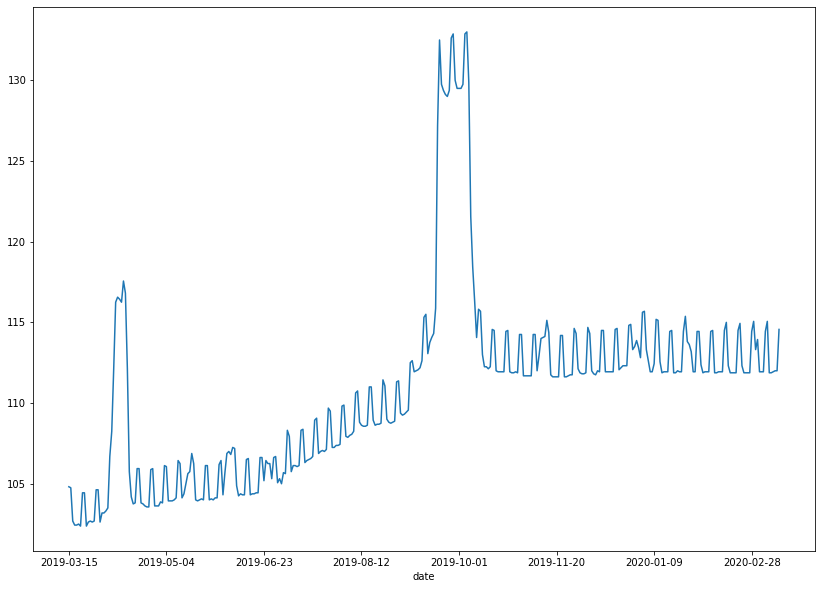

In [60]:
calendar[calendar["price"].notna()].groupby("date")["price"].mean().plot(figsize=(14,10))

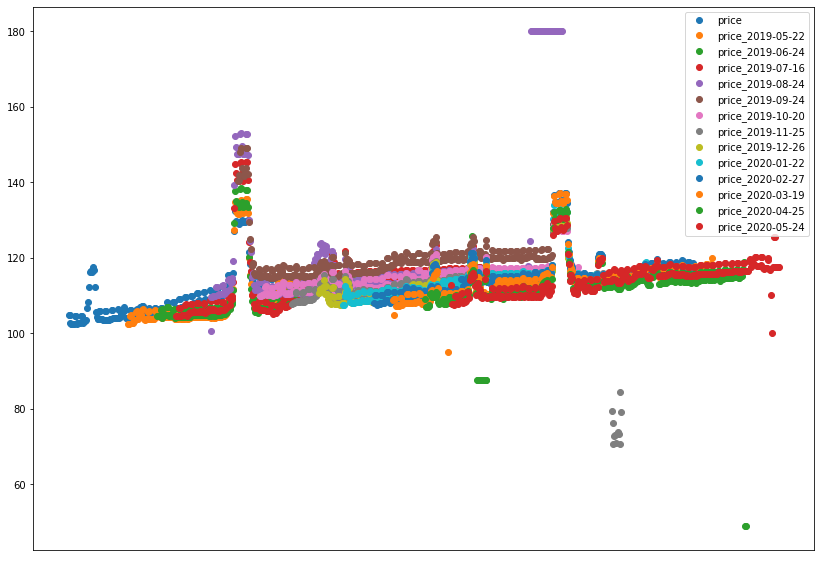

In [70]:

fig, ax = plt.subplots(figsize=(14,10))
for col in calendar.columns[calendar.columns.str.contains("price")]:
    ax.plot_date(calendar.loc[calendar[col].notna(),"date"].unique(),calendar[calendar[col].notna()].groupby("date")[col].mean(), label=col)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator())
monthFmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_formatter(monthFmt)
ax.legend()
plt.show()

listing_id                int64
date                     object
available                object
price                   float16
available_2019-05-22     object
price_2019-05-22        float16
available_2019-06-24     object
price_2019-06-24        float16
available_2019-07-16     object
price_2019-07-16        float16
available_2019-08-24     object
price_2019-08-24        float16
available_2019-09-24     object
price_2019-09-24        float16
available_2019-10-20     object
price_2019-10-20        float16
available_2019-11-25     object
price_2019-11-25        float16
available_2019-12-26     object
price_2019-12-26        float16
available_2020-01-22     object
price_2020-01-22        float16
available_2020-02-27     object
price_2020-02-27        float16
available_2020-03-19     object
price_2020-03-19        float16
available_2020-04-25     object
price_2020-04-25        float16
available_2020-05-24     object
price_2020-05-24        float16
dtype: object